In [17]:
import scipy.io as scio
import numpy as np    
import matplotlib.pyplot as plt
import sys
import os
import math
import cv2
from scipy.misc import imsave
import scipy.ndimage as ndimage
from unet import UNet
from loss import *
import torch
import torch.nn as nn
import heapq
from torch.autograd import Variable
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
value = 1
def get_info(filenames, ext, root):
    images = []
    for filename in filenames :
        filepath = os.path.join(root,filename)
        if ext == '.npy':
            image = np.load(filepath)
        elif ext == '.JPG' or ext == '.tif' or ext =='.png' or ext =='.tiff':
            image = ndimage.imread(filepath)
        images.append(image)
    return images

def get_data(directory,ext):
    from os import listdir
    from os.path import isfile, join
    
    root_path = ""
    filenames = [f for f in listdir(directory) if isfile(join(directory, f)) and f != '.DS_Store']
    filenames = sorted(filenames)
    return filenames, get_info(filenames, ext, directory)

In [19]:
cwd = os.getcwd()
filenames_im, images = get_data(cwd+'\medical_images\\oct_images\\Train','.png')
filenames_lb, lbs = get_data(cwd+'\medical_images\\training_set','.png')
print(len(filenames_im))


C:\Users\Ziyi Huang\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  if __name__ == '__main__':


124


In [20]:
model = UNet(n_channels=1, n_classes=2).cuda()
#model = nn.DataParallel(model)
PATH = os.getcwd() + '\\models\\model_noise_75_1_8\\1it\\seg_module.model'
model.load_state_dict(torch.load(PATH))
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): Dropout(p=0.2, inplace=False)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Dropout(p=0.2, inplace=False)
       

In [21]:
#from relaynet_pytorch.net_api.losses import CombinedLoss
loss_func=CombinedLoss()
total_loss = []

for j in range(len(filenames_im)):
    im = images[j].copy()
    w = np.ones([1,1,im.shape[0], im.shape[1]])
    label = lbs[j].reshape((1,im.shape[0], -1))
    im = im.reshape((1,1,im.shape[0], -1))    
    im = torch.from_numpy(im) 
    w = torch.from_numpy(w) 
    label = torch.from_numpy(label)

    y = Variable(label).cuda().float()
    X = Variable(im).cuda().float()
    w = Variable(w).cuda().float()
    output = model(X)
    output2 = output.data.cpu().numpy()
    output2 = np.squeeze(output2[0])
    output2 = np.argmax(output2,0)
    output2 = np.squeeze(output2)

    loss = loss_func(output.float(), y.float(), w.float(), num_classes = 2)
    total_loss.append(loss[2].item())
print(total_loss)

[1.2797727584838867, 1.0016155242919922, 0.8511327505111694, 1.1097756624221802, 1.210240125656128, 0.94822096824646, 1.1653844118118286, 1.2921509742736816, 0.9394708871841431, 1.4610326290130615, 1.0935412645339966, 1.1021854877471924, 0.6361798644065857, 0.994236409664154, 0.5367693901062012, 0.925344705581665, 0.7057565450668335, 1.1148886680603027, 1.0667645931243896, 0.6573690176010132, 0.9434240460395813, 0.9464813470840454, 1.251722812652588, 1.2353298664093018, 0.9803208112716675, 0.9819020628929138, 1.0462077856063843, 1.0637074708938599, 0.9192831516265869, 0.8326811790466309, 0.9554418921470642, 0.8510768413543701, 0.9673542380332947, 0.8169209957122803, 1.2363841533660889, 0.8797508478164673, 1.086794137954712, 1.2166709899902344, 0.8488103151321411, 1.0872159004211426, 1.3654705286026, 1.0354022979736328, 0.6867282390594482, 1.1084579229354858, 1.108879566192627, 1.3265702724456787, 1.5738310813903809, 0.9763148427009583, 1.2535674571990967, 0.986487865447998, 1.624168872

In [22]:
# sort the loss values
nlevel = 0.75
max_indexes = map(total_loss.index, heapq.nlargest(int(124*nlevel), total_loss))
max_index_k = list(max_indexes)
#print(len(max_index_k), max_index_k)
#for index_k in max_index_k:
    #print(total_loss[index_k])

In [23]:
cwd = os.getcwd()
check_directory = cwd
filenames_lb, lbs = get_data(cwd+'\medical_images\\\\training_set','.png')
filenames_pred, pred = get_data(cwd+'\\medical_images\\prediction','.png')
filenames_gt, gts = get_data(cwd+'\medical_images\\odd_gt','.png')
gts = np.array(gts)
gts[gts >1] =1
print(len(filenames_lb))
print(len(filenames_pred))

C:\Users\Ziyi Huang\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  if __name__ == '__main__':


124
124


CONVERT_JPCLN001.png


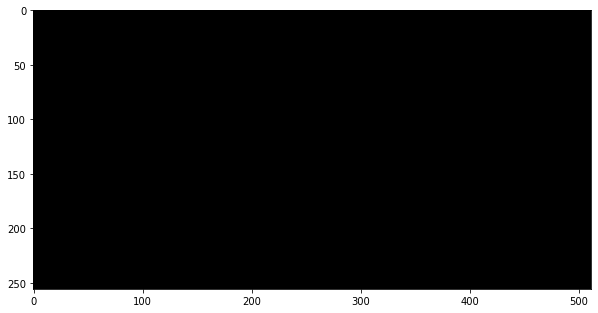

noisy


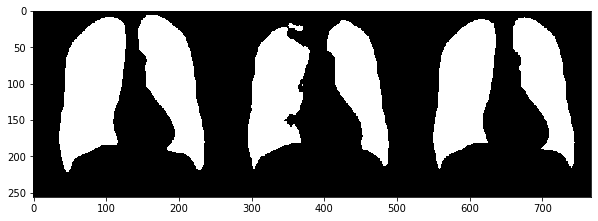

CONVERT_JPCLN003.png


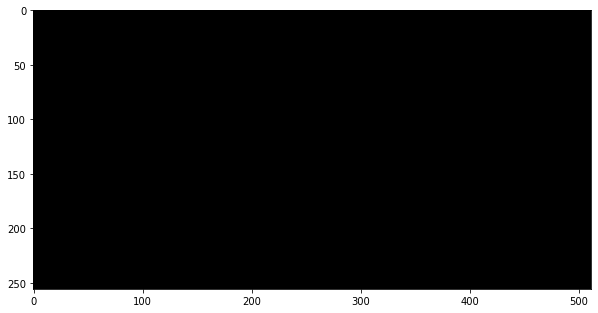

noisy


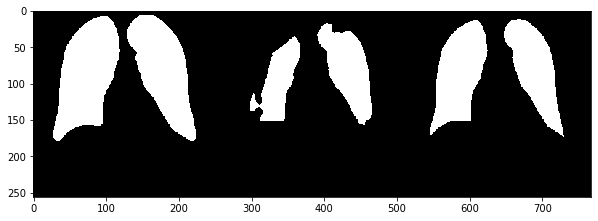

CONVERT_JPCLN005.png
CONVERT_JPCLN007.png


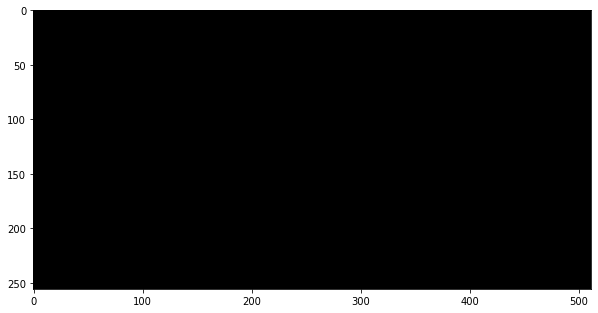

clean


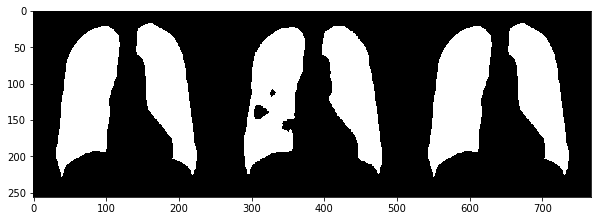

CONVERT_JPCLN009.png


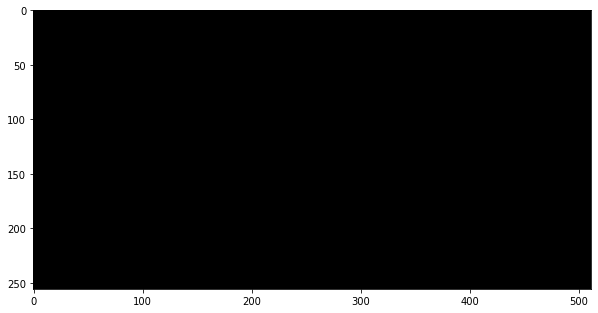

noisy


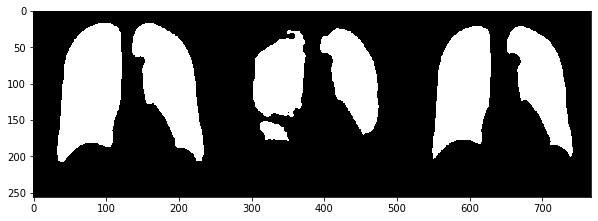

CONVERT_JPCLN011.png


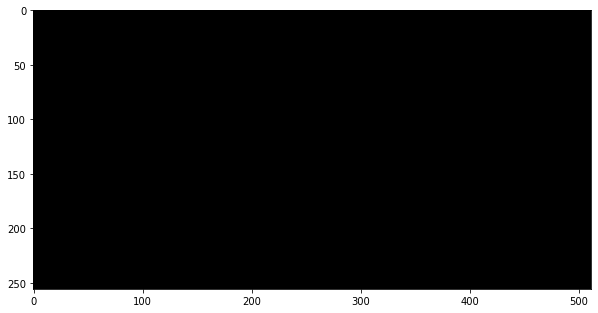

noisy


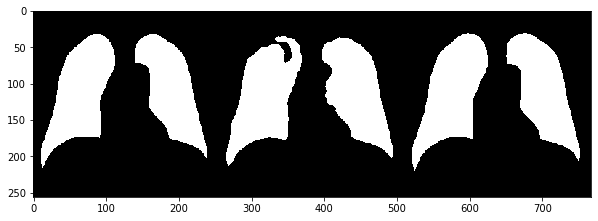

CONVERT_JPCLN013.png


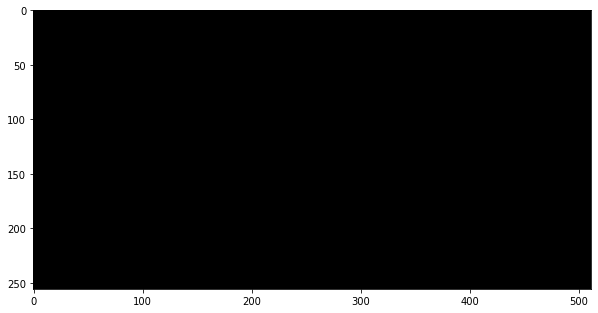

noisy


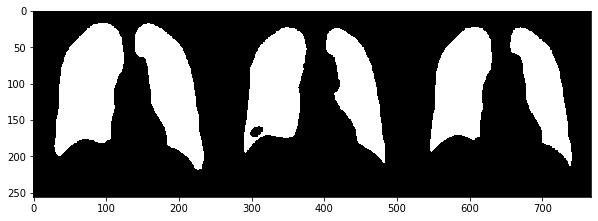

CONVERT_JPCLN015.png


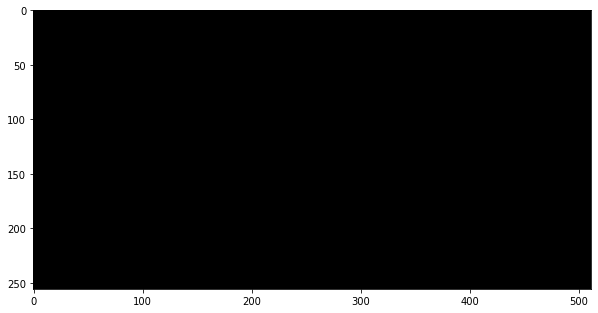

noisy


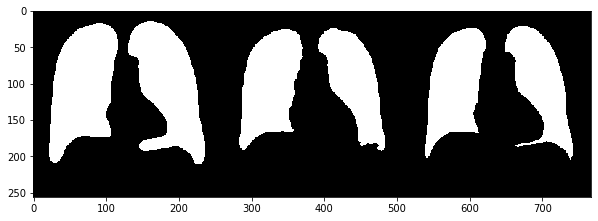

CONVERT_JPCLN017.png


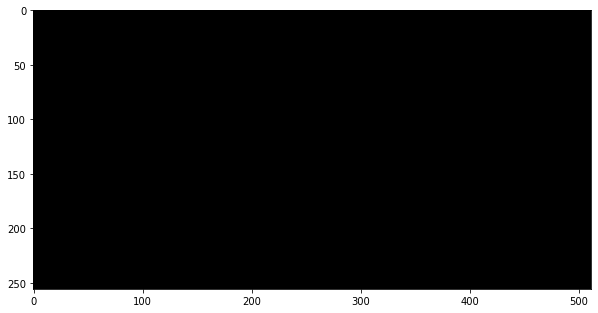

noisy


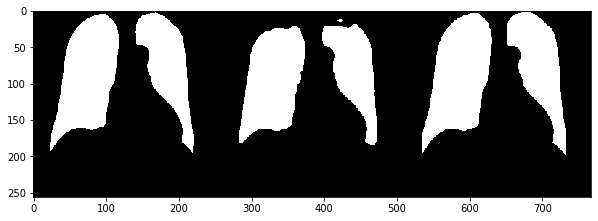

CONVERT_JPCLN019.png


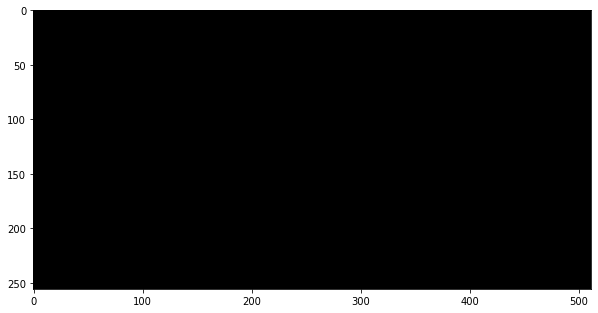

noisy


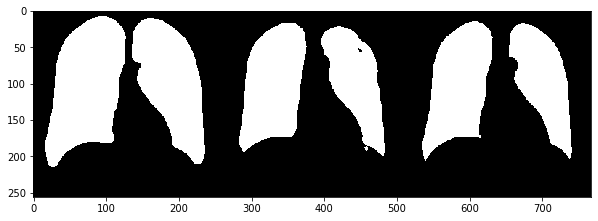

CONVERT_JPCLN021.png


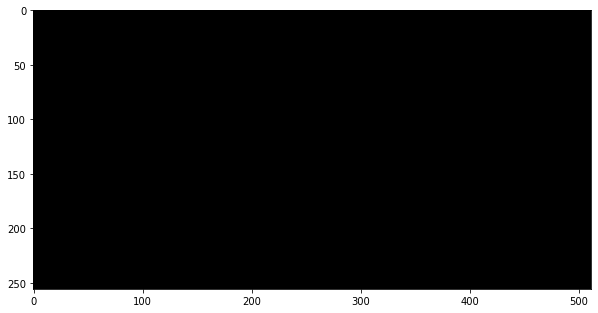

clean


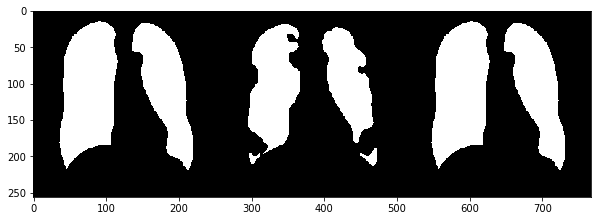

CONVERT_JPCLN023.png


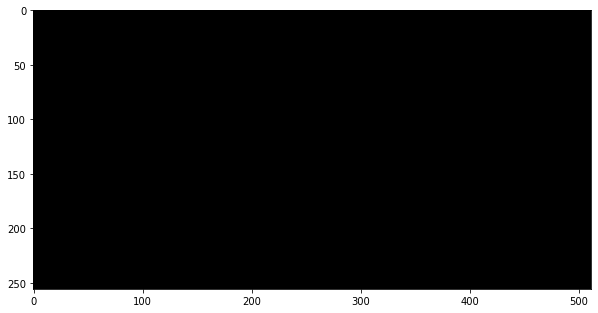

clean


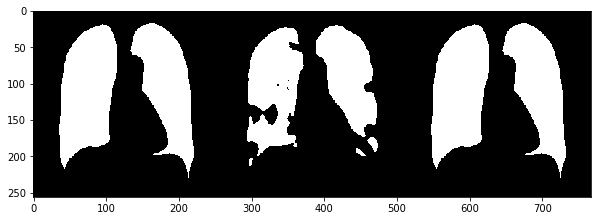

CONVERT_JPCLN025.png
CONVERT_JPCLN027.png


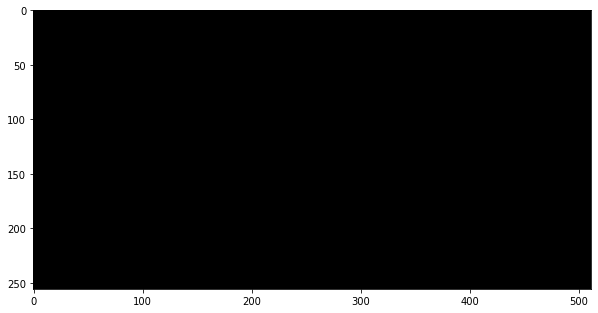

noisy


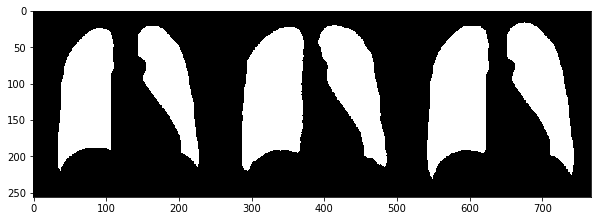

CONVERT_JPCLN029.png
CONVERT_JPCLN031.png


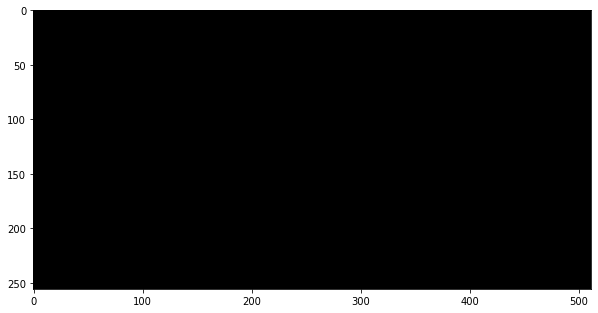

noisy


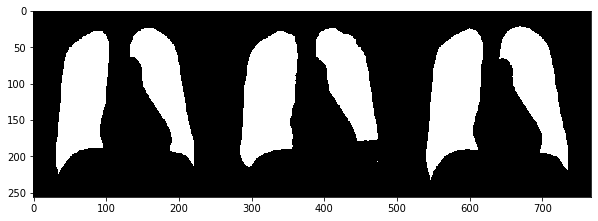

CONVERT_JPCLN033.png
CONVERT_JPCLN035.png


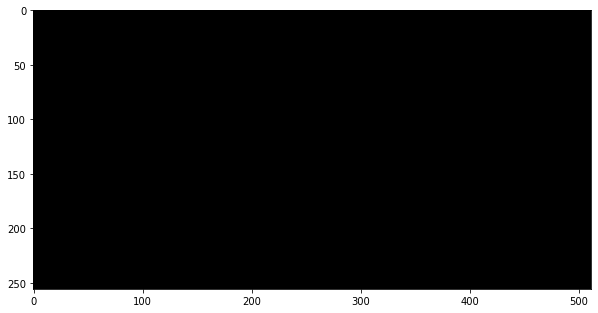

noisy


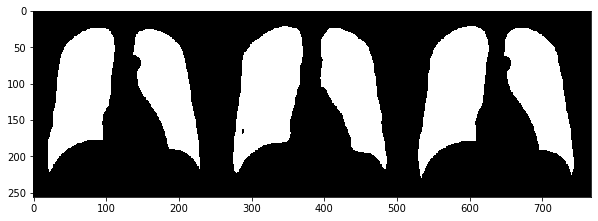

CONVERT_JPCLN037.png


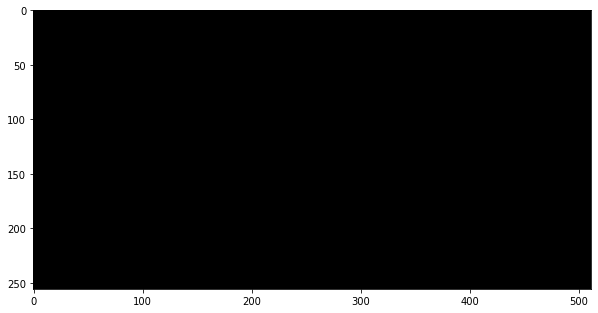

noisy


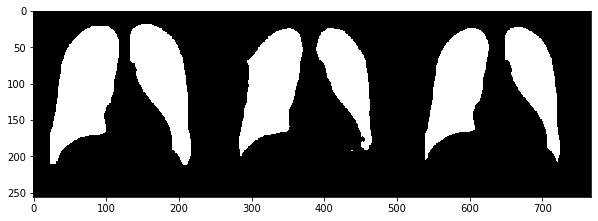

CONVERT_JPCLN039.png
CONVERT_JPCLN041.png


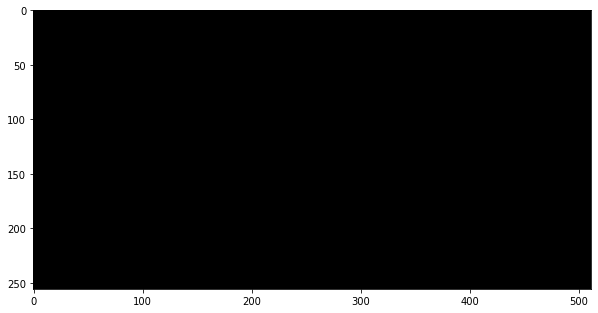

noisy


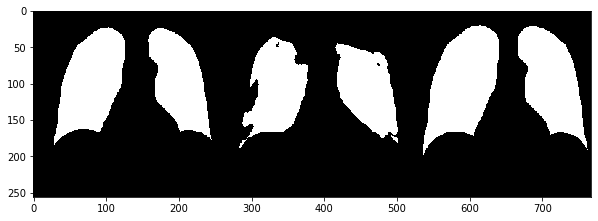

CONVERT_JPCLN043.png


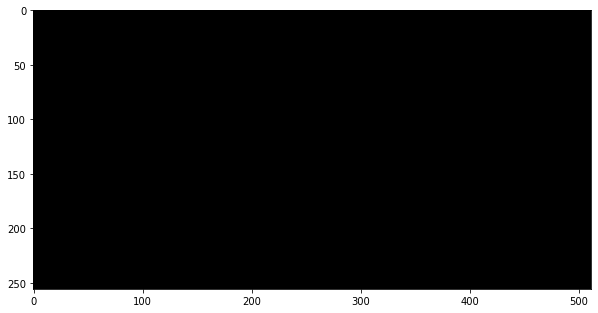

clean


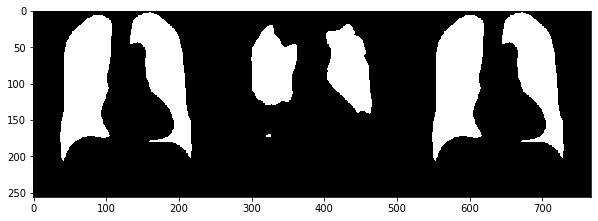

CONVERT_JPCLN045.png


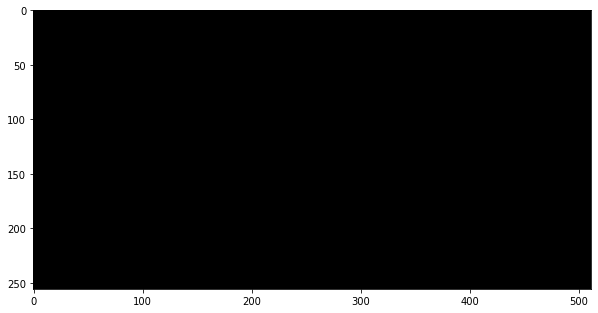

clean


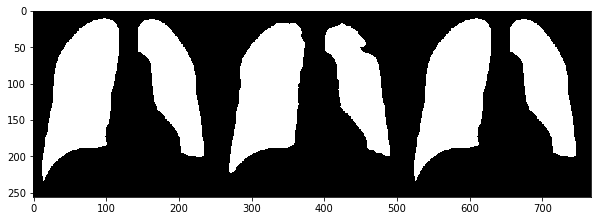

CONVERT_JPCLN047.png


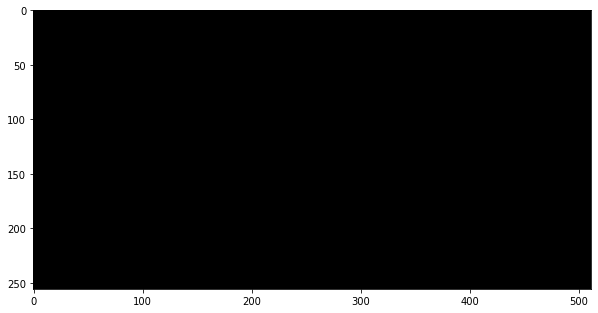

clean


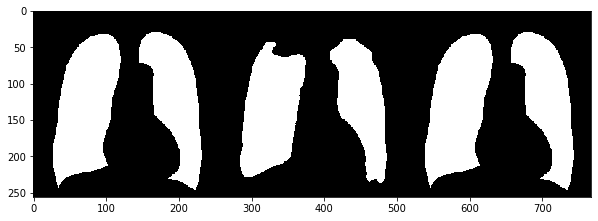

CONVERT_JPCLN049.png


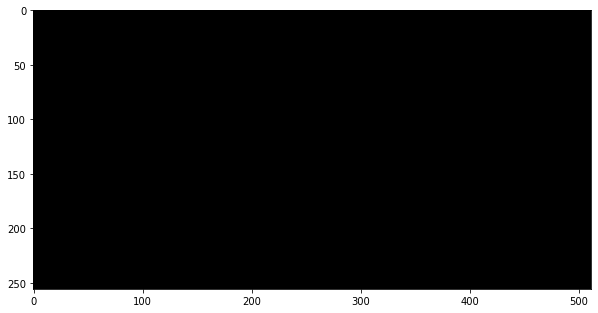

noisy


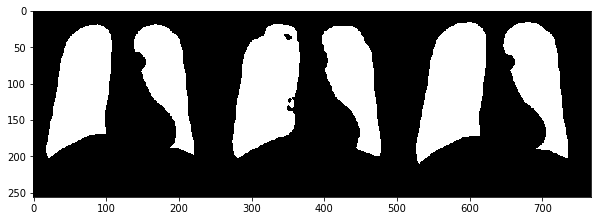

CONVERT_JPCLN051.png


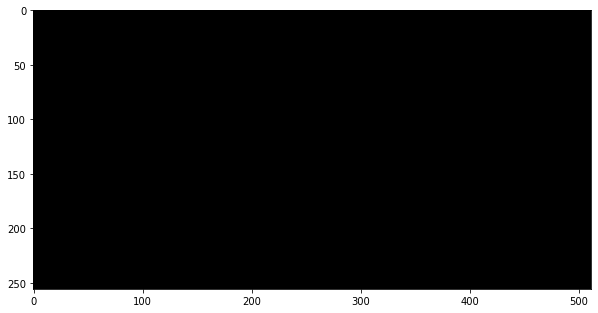

clean


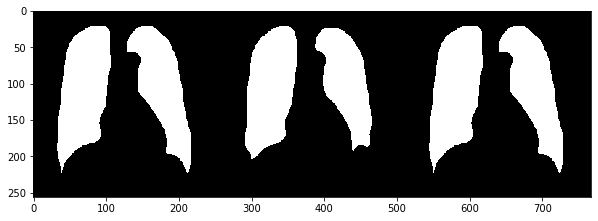

CONVERT_JPCLN053.png


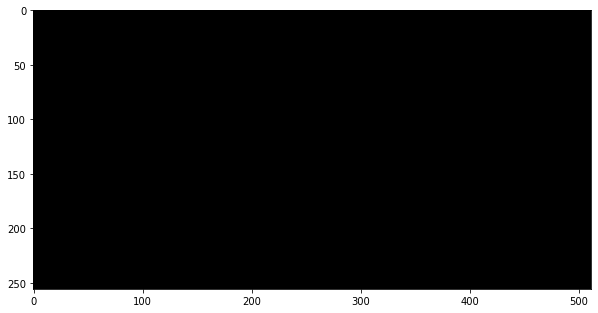

noisy


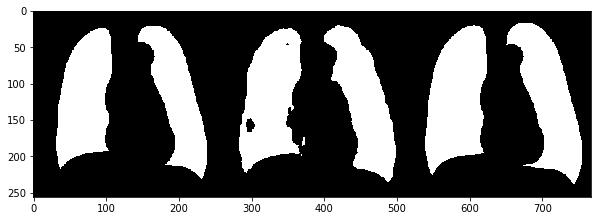

CONVERT_JPCLN055.png


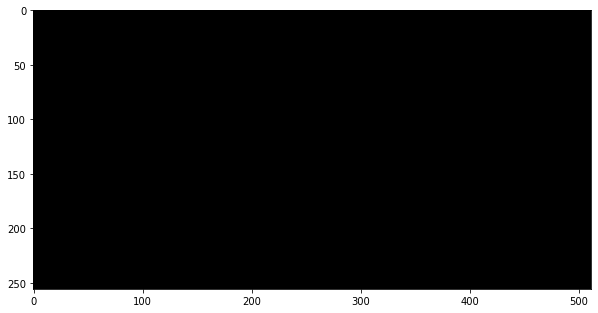

noisy


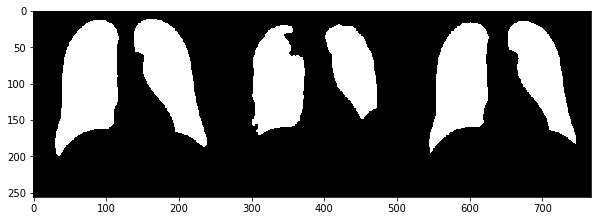

CONVERT_JPCLN057.png


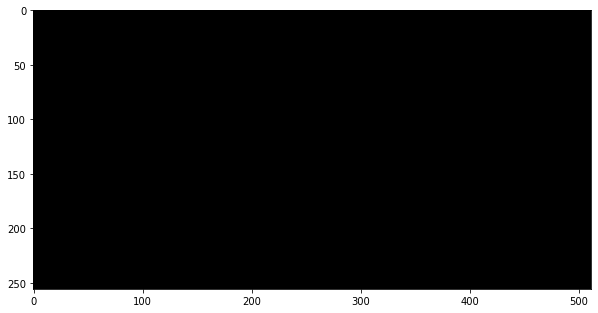

noisy


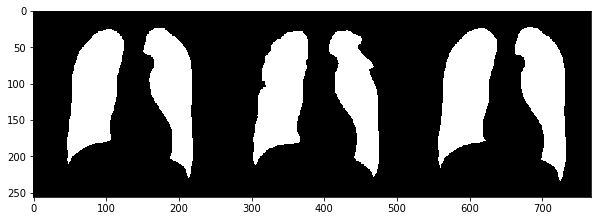

CONVERT_JPCLN059.png
CONVERT_JPCLN061.png


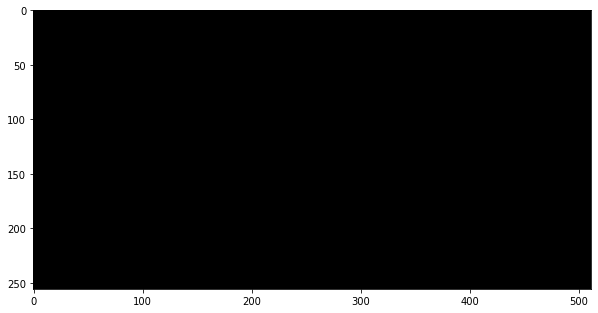

noisy


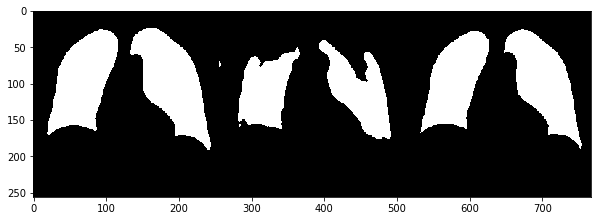

CONVERT_JPCLN063.png
CONVERT_JPCLN065.png


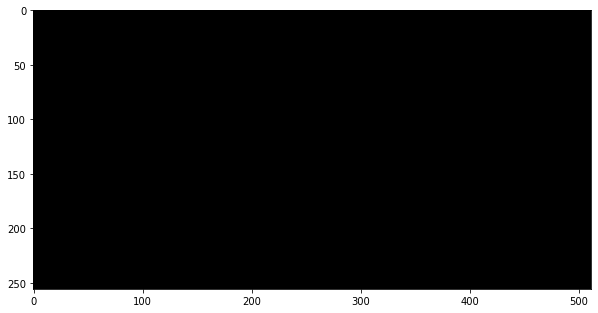

clean


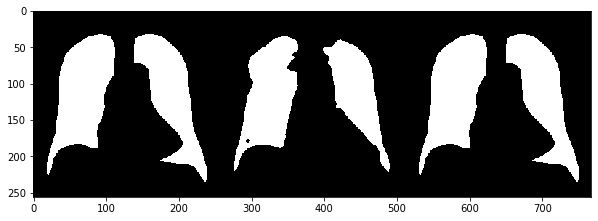

CONVERT_JPCLN067.png
CONVERT_JPCLN069.png


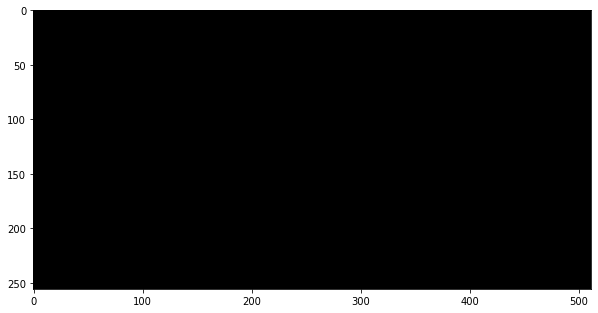

noisy


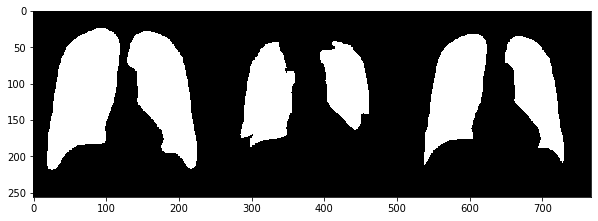

CONVERT_JPCLN071.png
CONVERT_JPCLN073.png


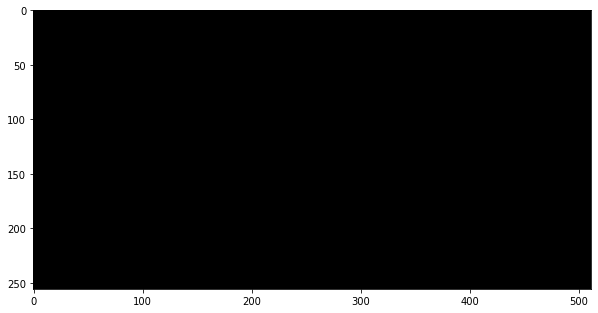

clean


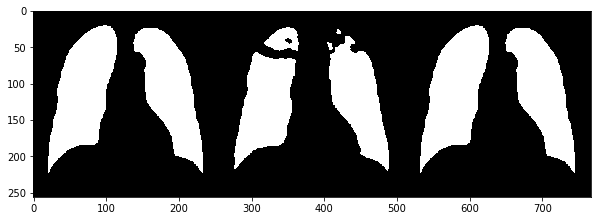

CONVERT_JPCLN075.png


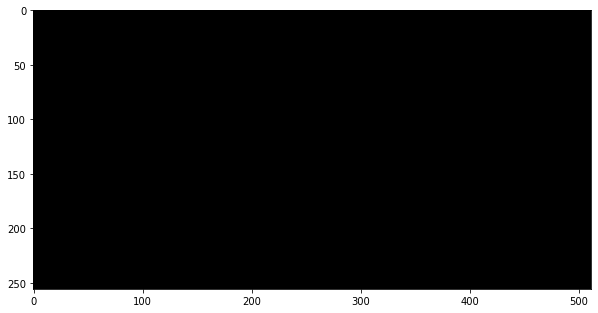

clean


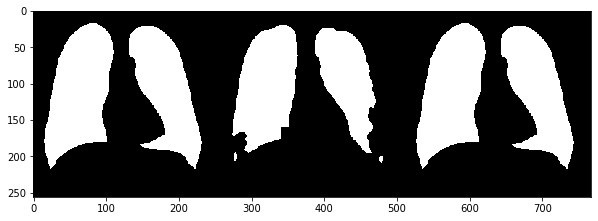

CONVERT_JPCLN077.png
CONVERT_JPCLN079.png


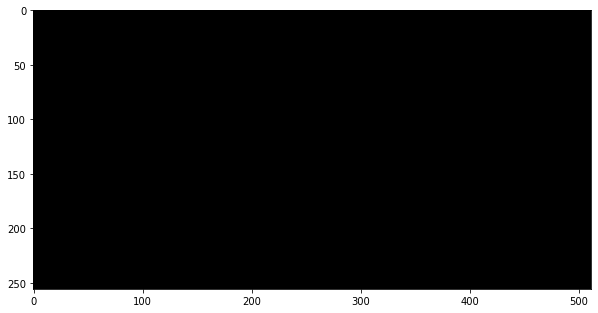

clean


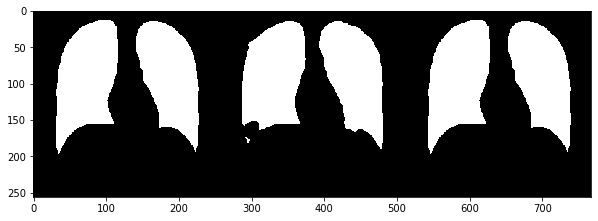

CONVERT_JPCLN081.png


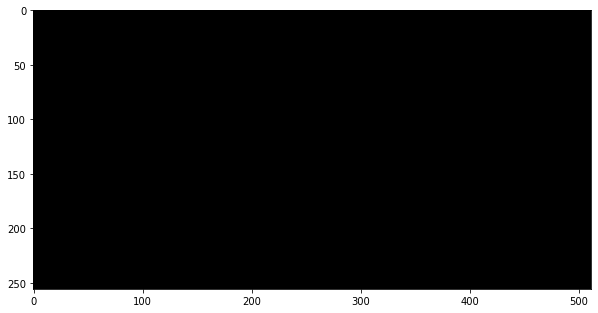

noisy


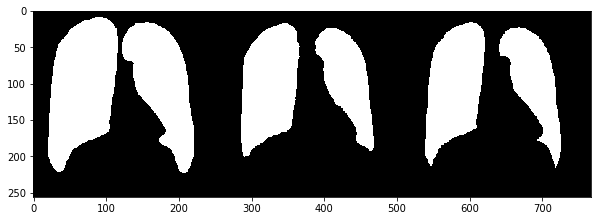

CONVERT_JPCLN083.png


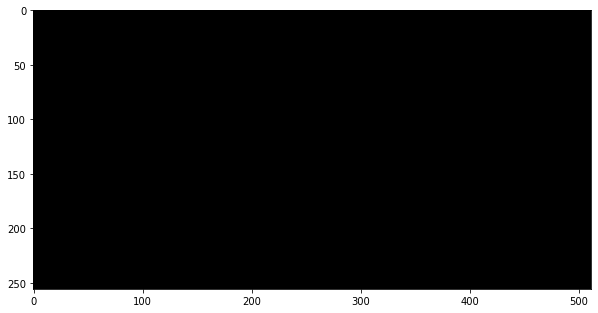

noisy


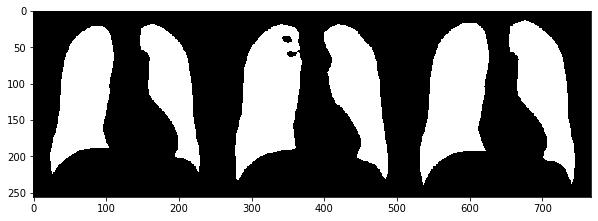

CONVERT_JPCLN085.png
CONVERT_JPCLN087.png


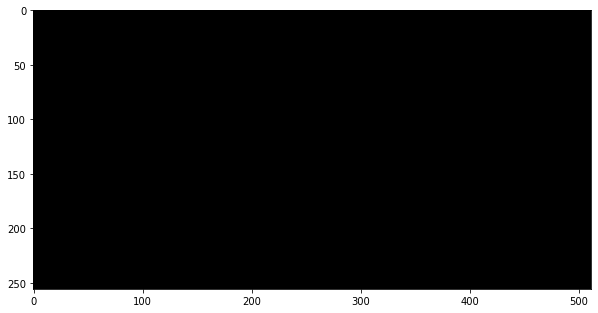

clean


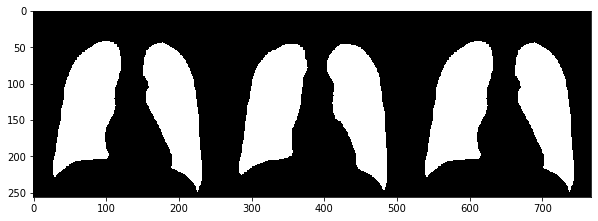

CONVERT_JPCLN089.png


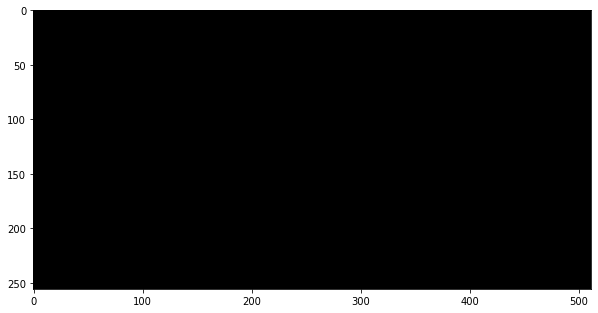

noisy


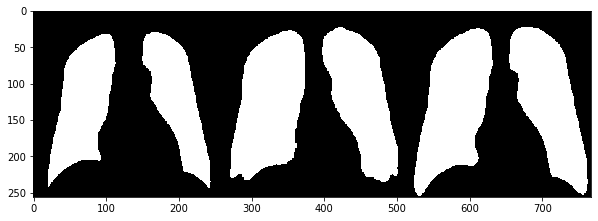

CONVERT_JPCLN091.png


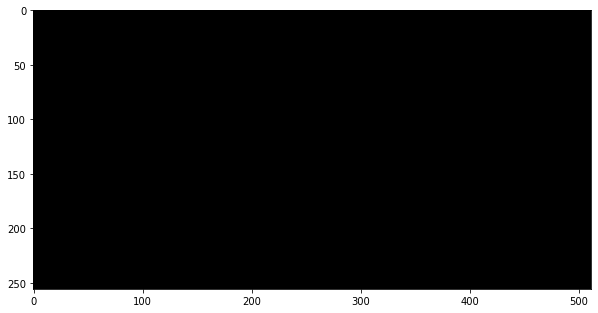

noisy


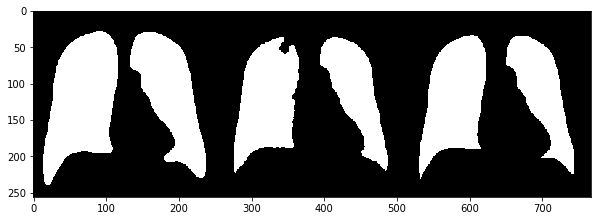

CONVERT_JPCLN093.png


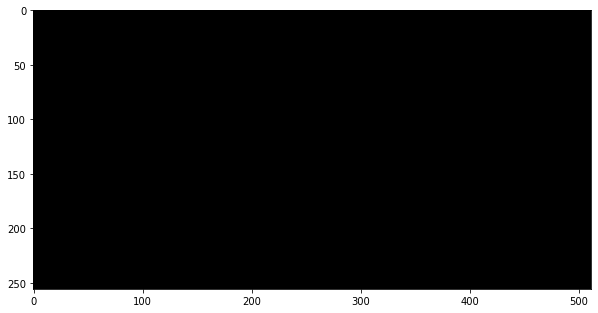

noisy


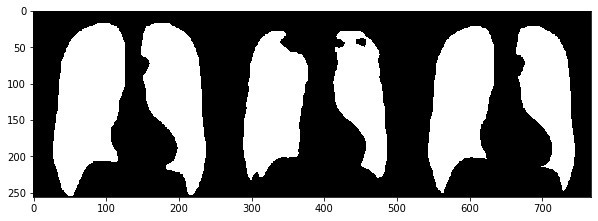

CONVERT_JPCLN095.png


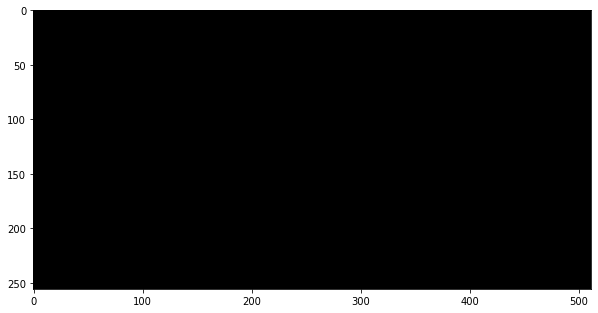

noisy


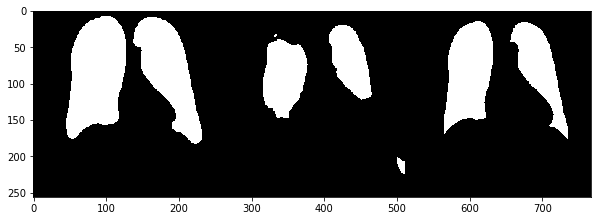

CONVERT_JPCLN097.png


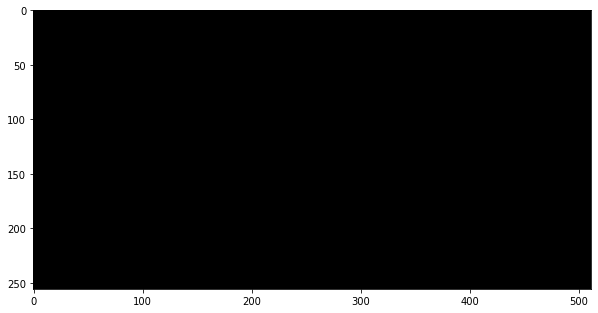

noisy


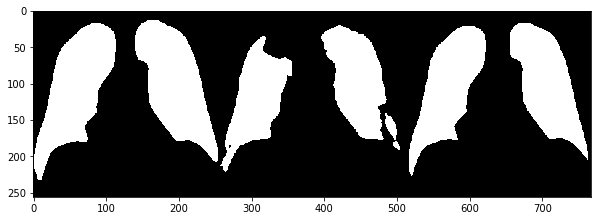

CONVERT_JPCLN099.png


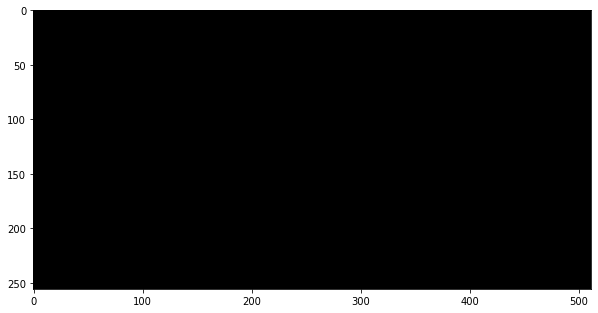

noisy


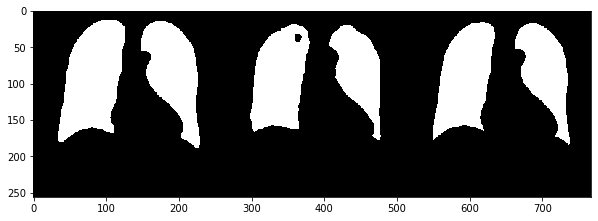

CONVERT_JPCLN101.png


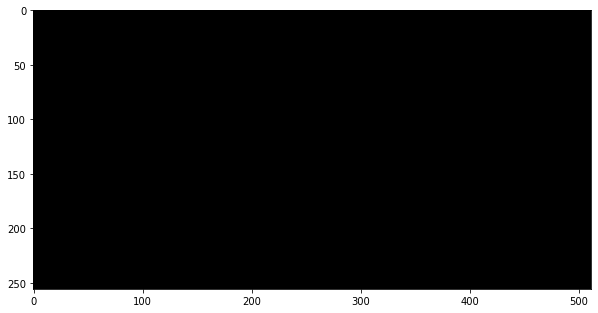

noisy


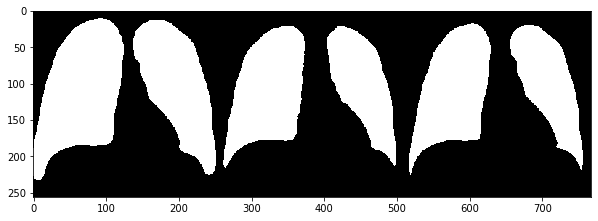

CONVERT_JPCLN103.png


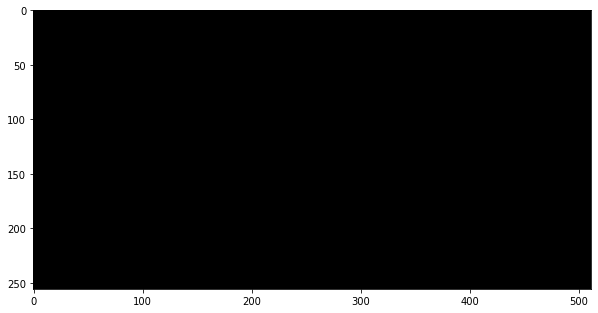

noisy


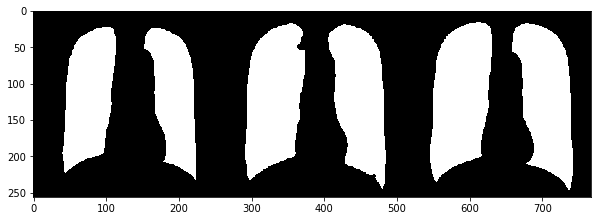

CONVERT_JPCLN105.png
CONVERT_JPCLN107.png


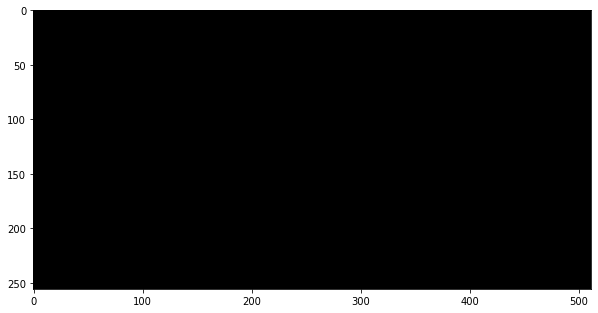

noisy


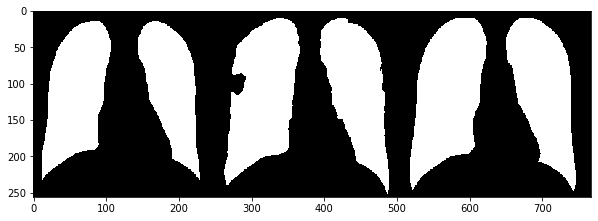

CONVERT_JPCLN109.png


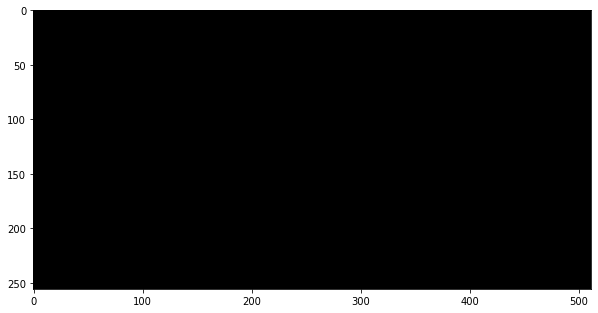

noisy


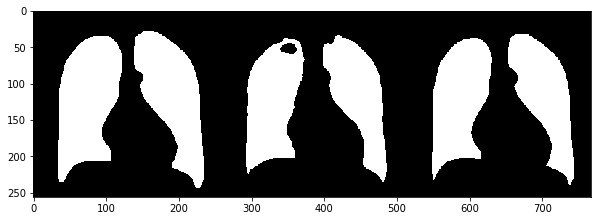

CONVERT_JPCLN111.png


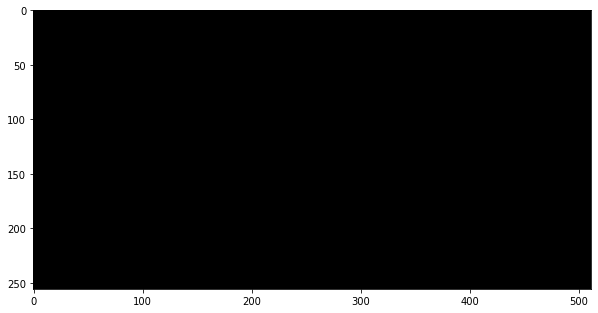

clean


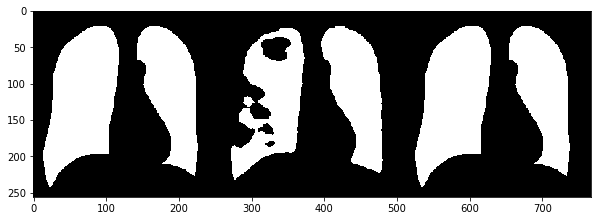

CONVERT_JPCLN113.png


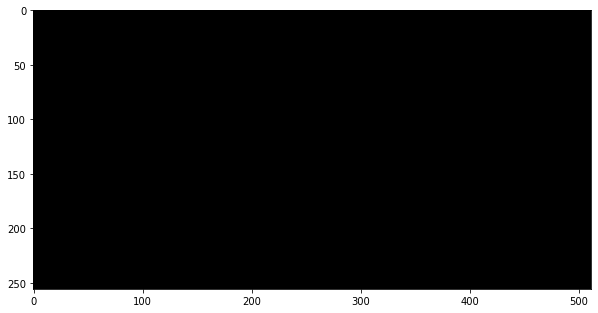

noisy


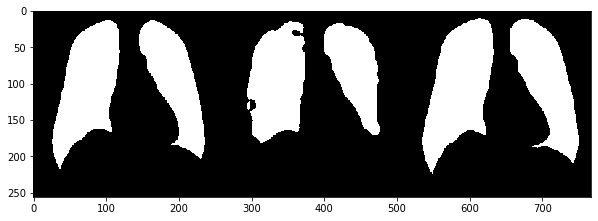

CONVERT_JPCLN115.png


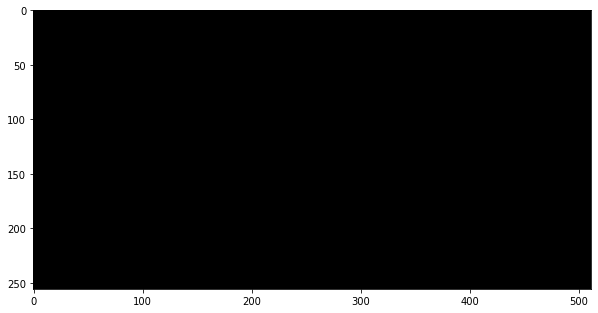

clean


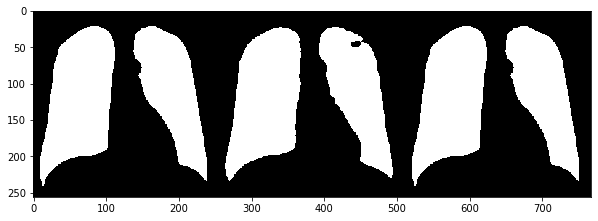

CONVERT_JPCLN117.png
CONVERT_JPCLN119.png
CONVERT_JPCLN121.png


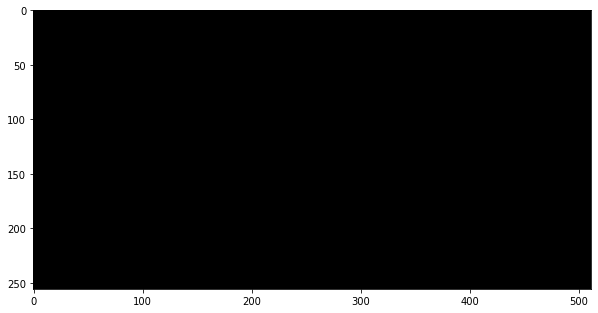

clean


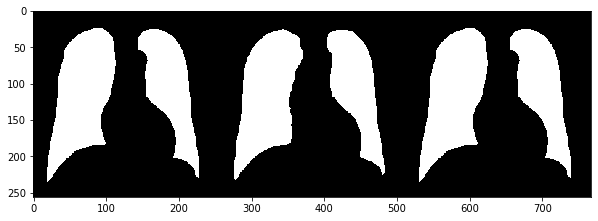

CONVERT_JPCLN123.png


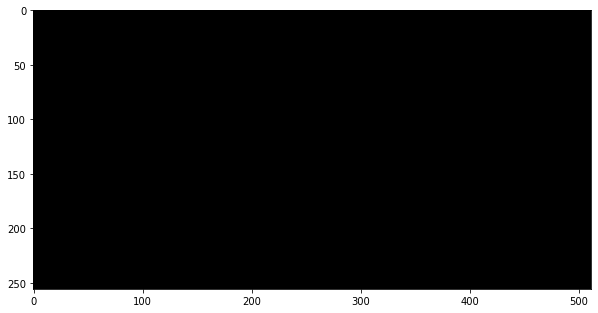

clean


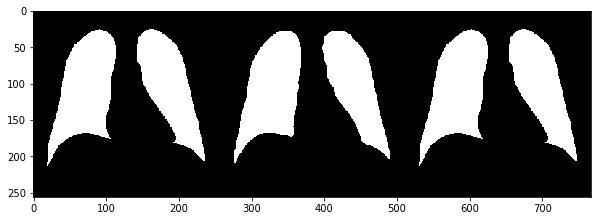

CONVERT_JPCLN125.png


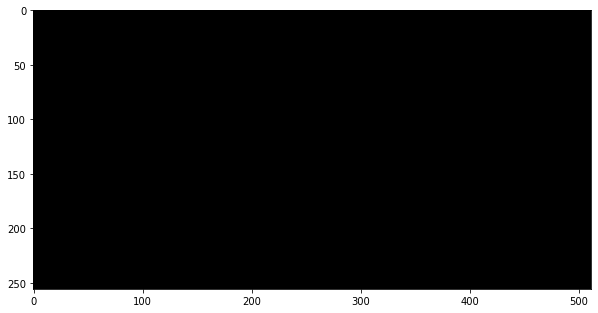

clean


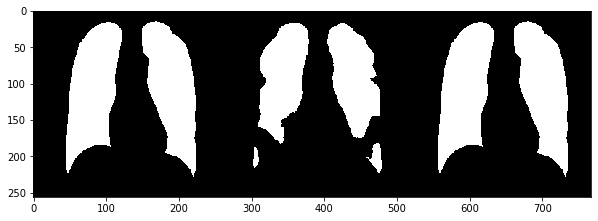

CONVERT_JPCLN127.png
CONVERT_JPCLN129.png


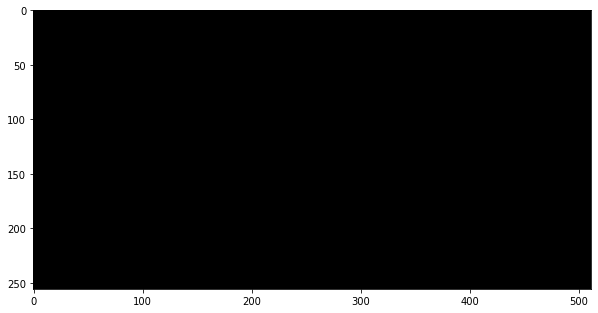

noisy


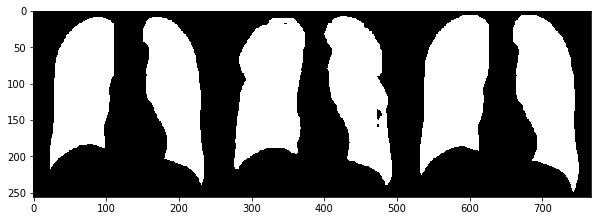

CONVERT_JPCLN131.png
CONVERT_JPCLN133.png


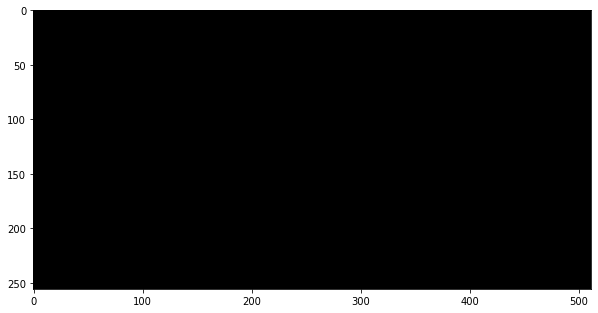

noisy


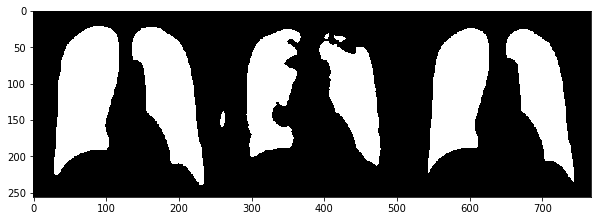

CONVERT_JPCLN135.png
CONVERT_JPCLN137.png
CONVERT_JPCLN139.png


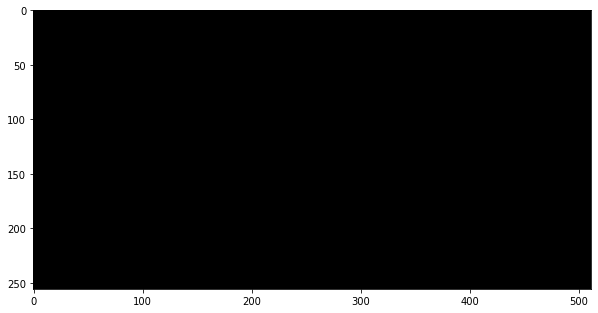

noisy


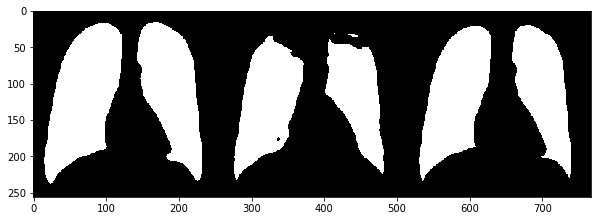

CONVERT_JPCLN141.png


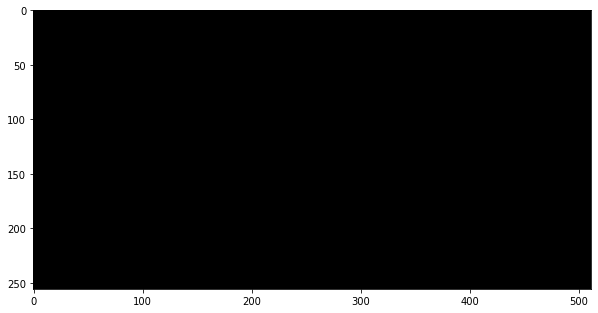

noisy


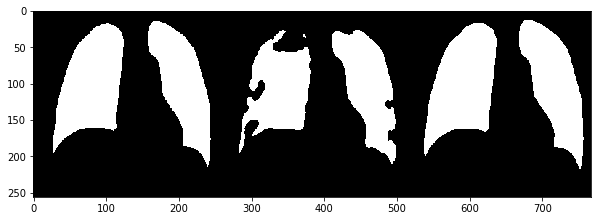

CONVERT_JPCLN143.png


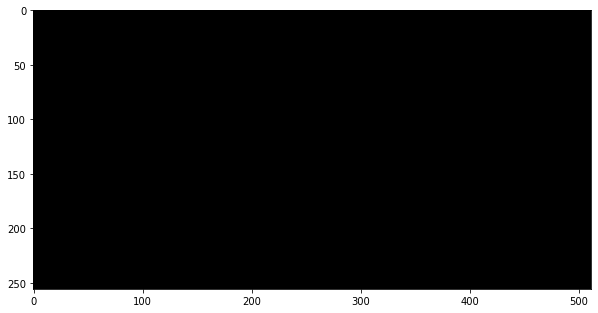

noisy


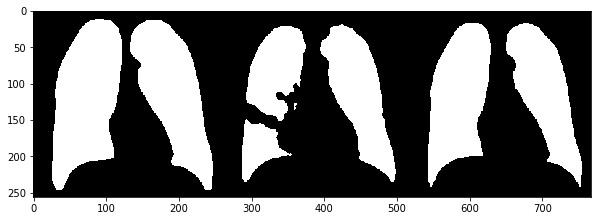

CONVERT_JPCLN145.png
CONVERT_JPCLN147.png


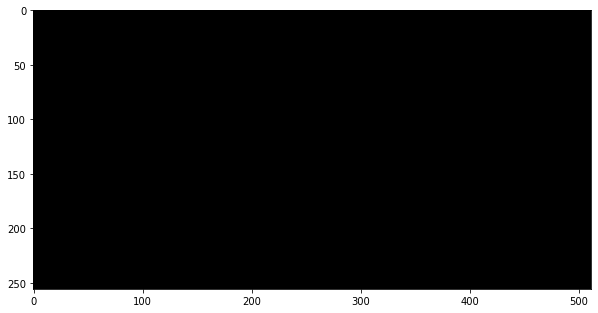

clean


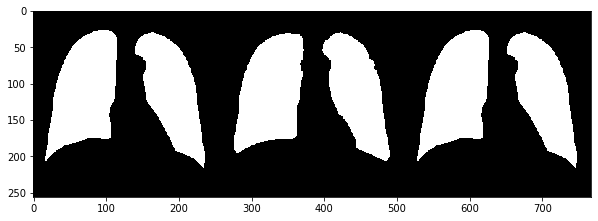

CONVERT_JPCLN149.png
CONVERT_JPCLN151.png
CONVERT_JPCLN153.png


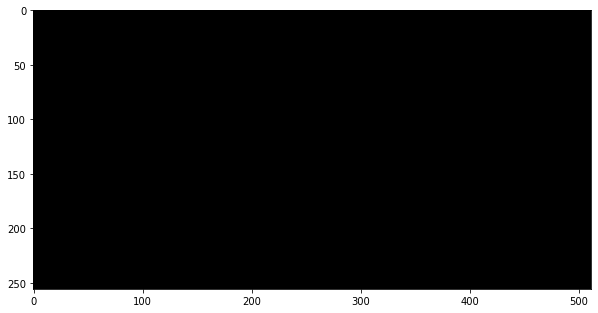

noisy


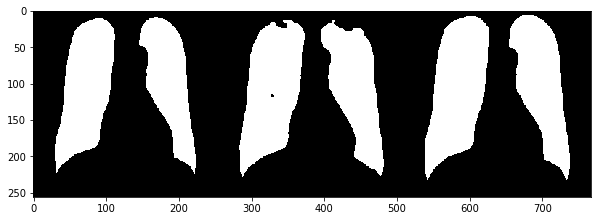

CONVERT_JPCNN001.png


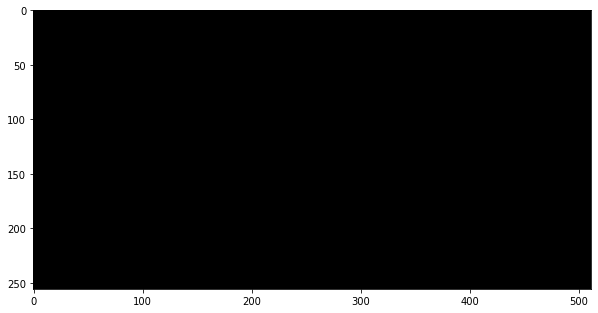

noisy


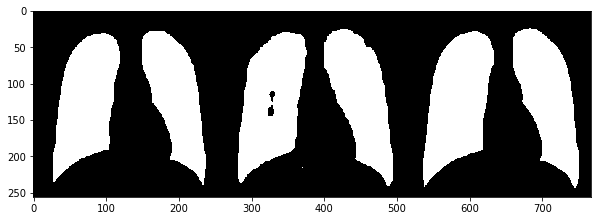

CONVERT_JPCNN003.png


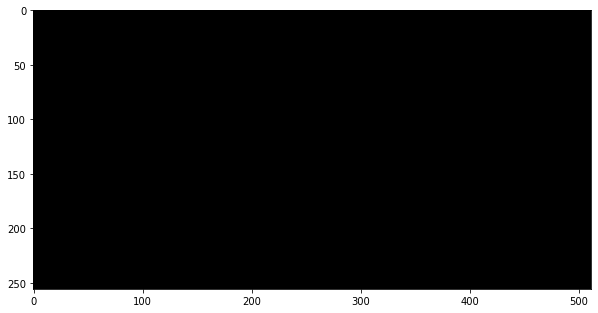

noisy


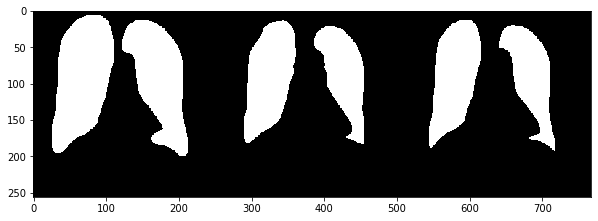

CONVERT_JPCNN005.png


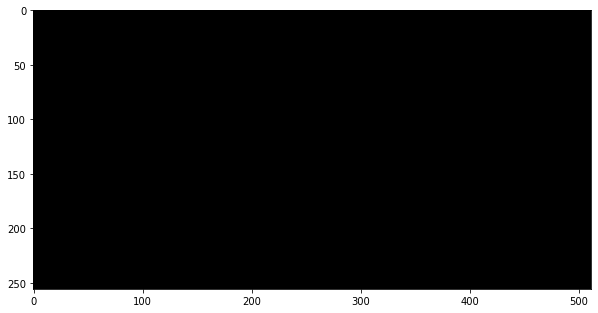

noisy


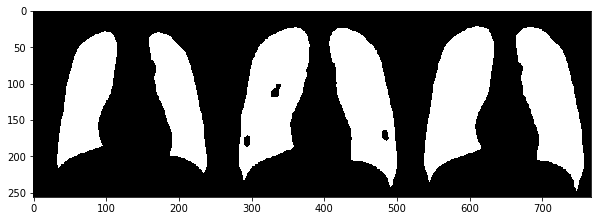

CONVERT_JPCNN007.png


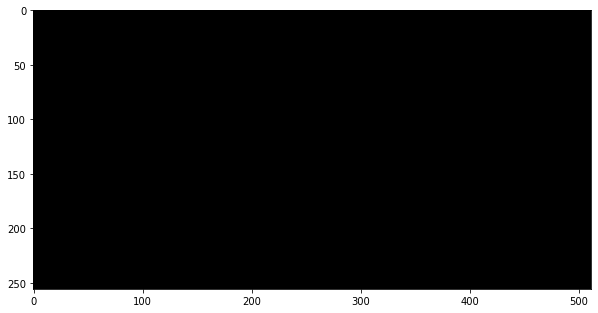

noisy


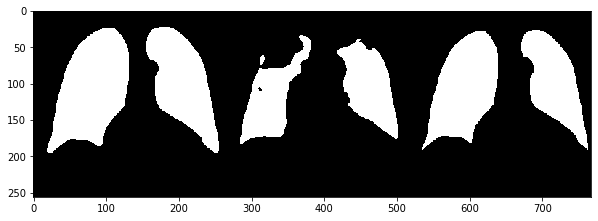

CONVERT_JPCNN009.png


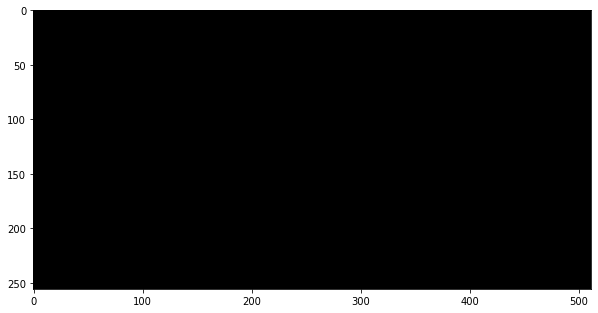

clean


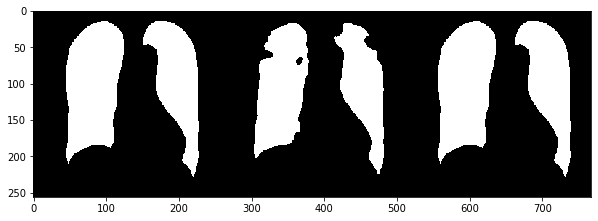

CONVERT_JPCNN011.png


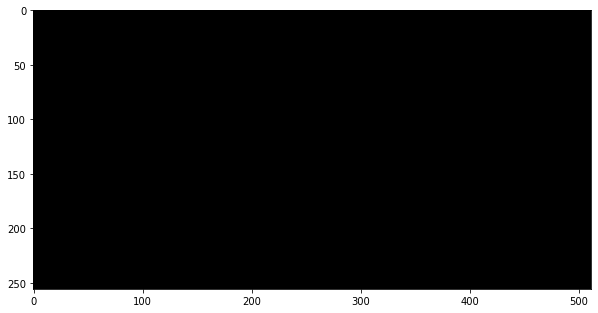

clean


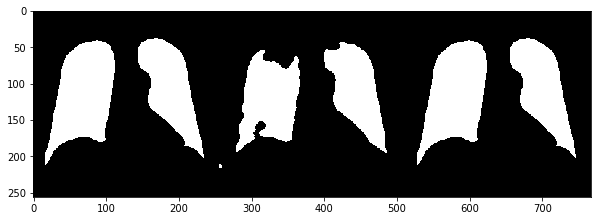

CONVERT_JPCNN013.png


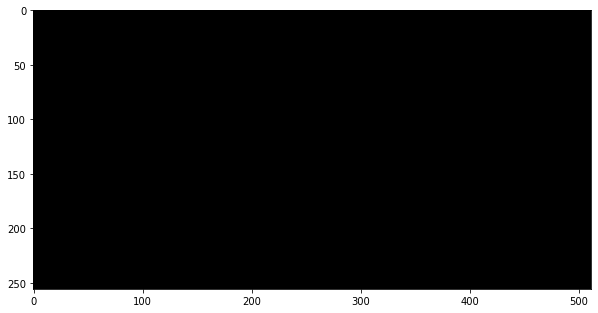

noisy


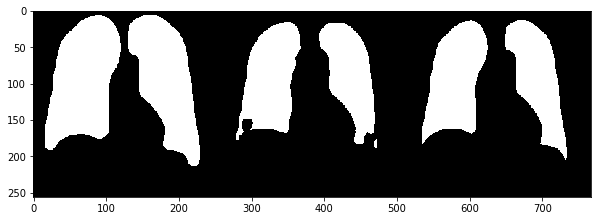

CONVERT_JPCNN015.png


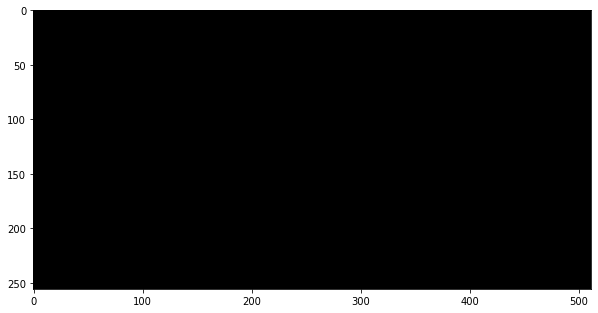

noisy


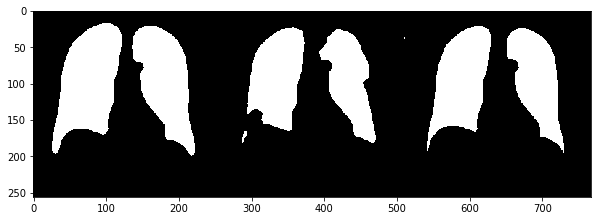

CONVERT_JPCNN017.png
CONVERT_JPCNN019.png


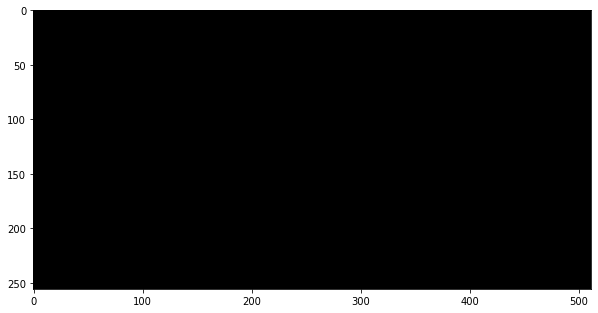

clean


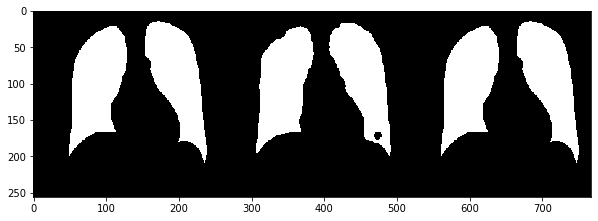

CONVERT_JPCNN021.png


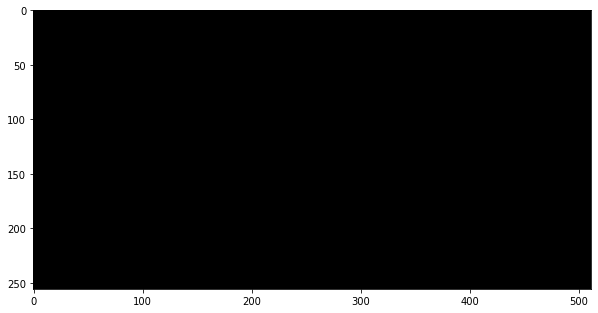

noisy


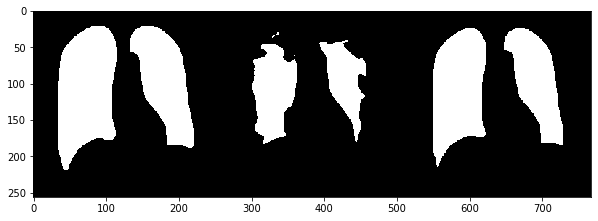

CONVERT_JPCNN023.png


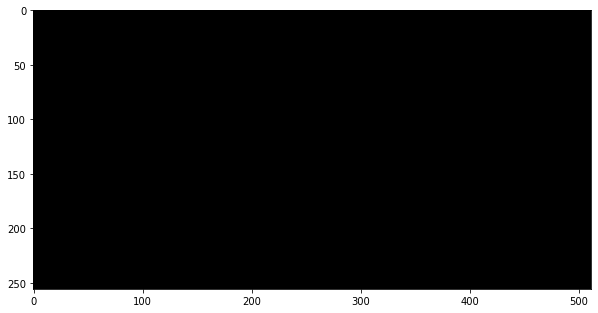

noisy


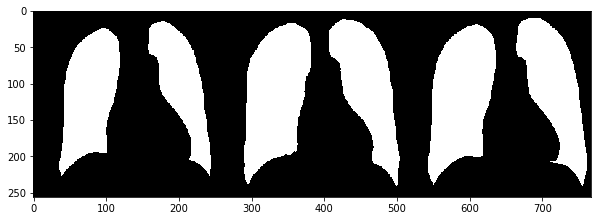

CONVERT_JPCNN025.png


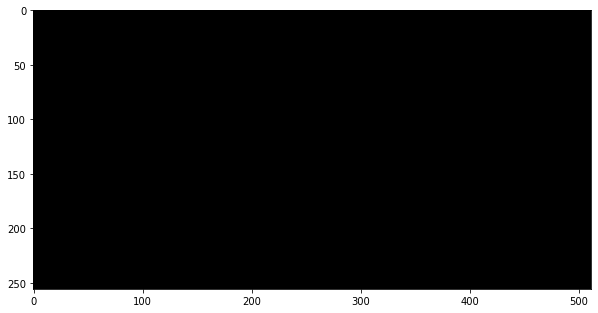

noisy


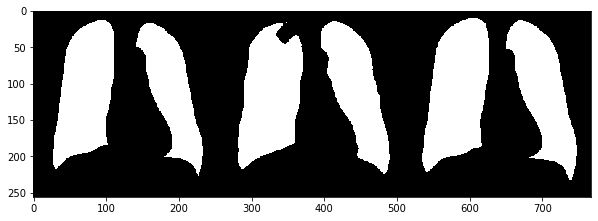

CONVERT_JPCNN027.png
CONVERT_JPCNN029.png
CONVERT_JPCNN031.png


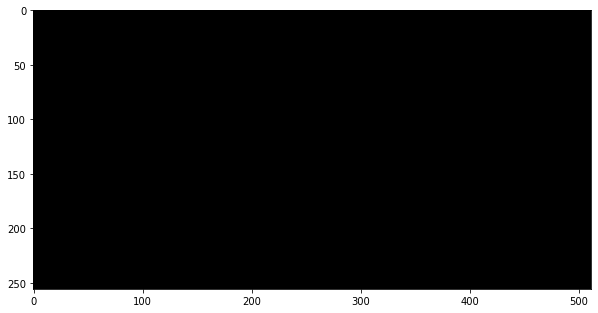

noisy


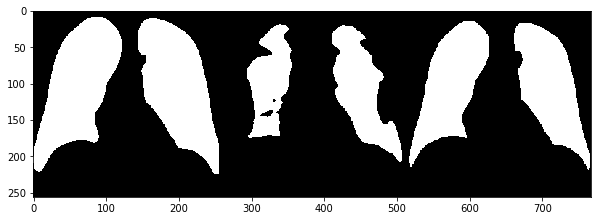

CONVERT_JPCNN033.png


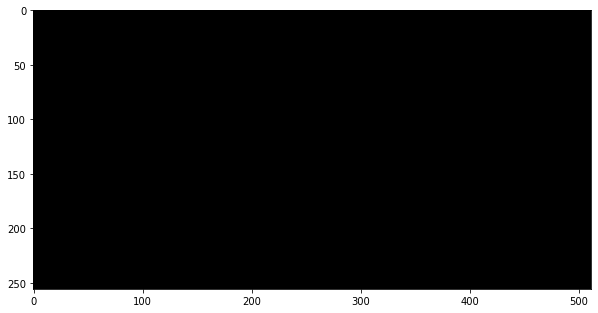

clean


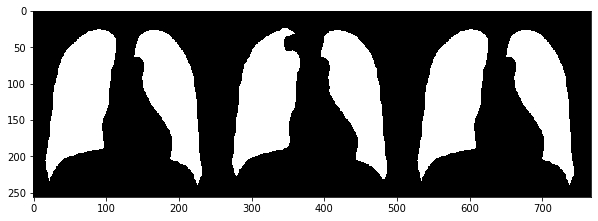

CONVERT_JPCNN035.png
CONVERT_JPCNN037.png


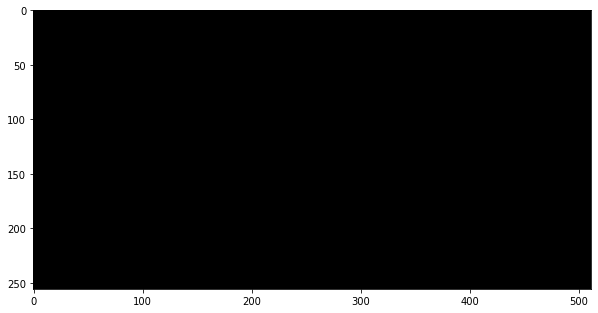

clean


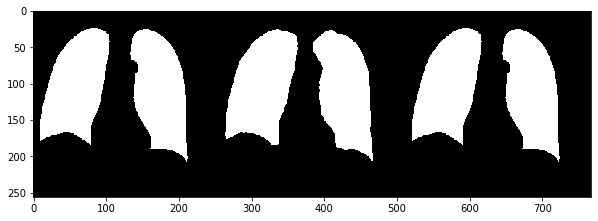

CONVERT_JPCNN039.png


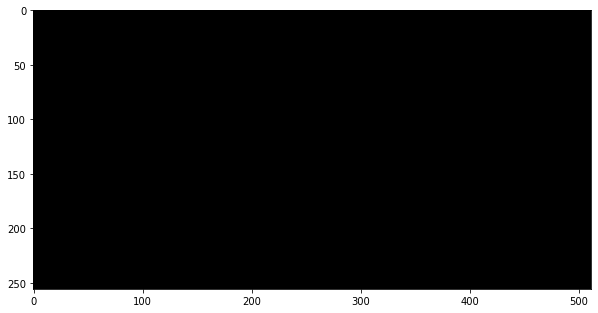

noisy


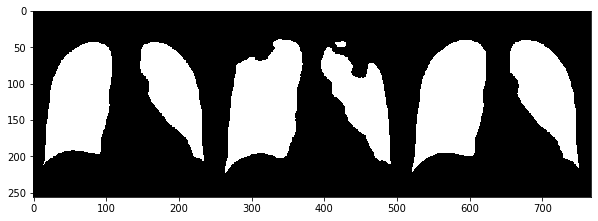

CONVERT_JPCNN041.png
CONVERT_JPCNN043.png


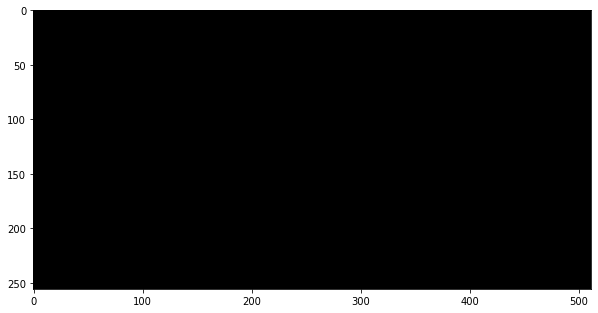

noisy


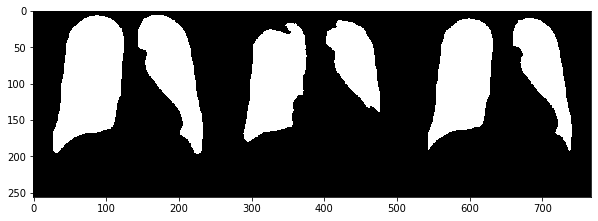

CONVERT_JPCNN045.png


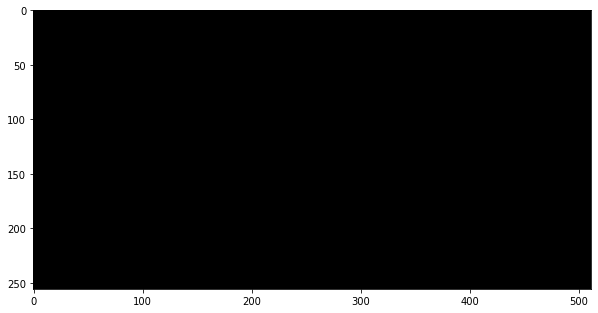

clean


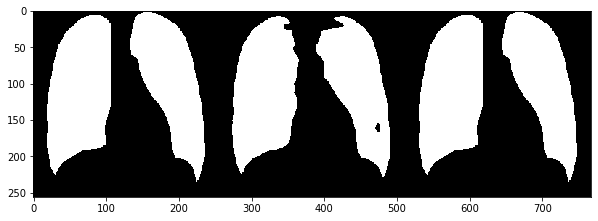

CONVERT_JPCNN047.png


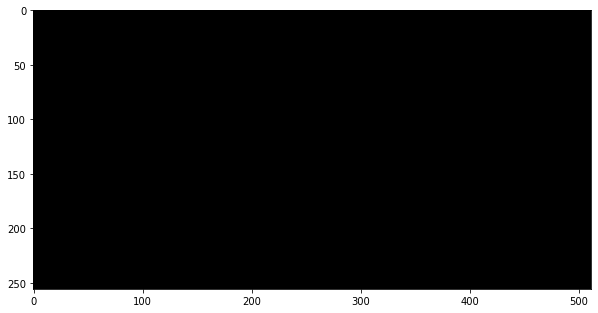

noisy


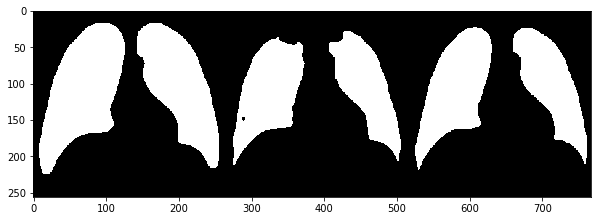

CONVERT_JPCNN049.png


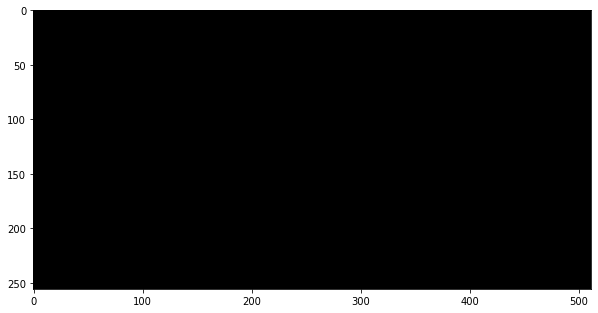

noisy


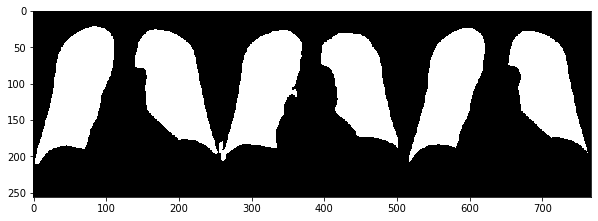

CONVERT_JPCNN051.png
CONVERT_JPCNN053.png


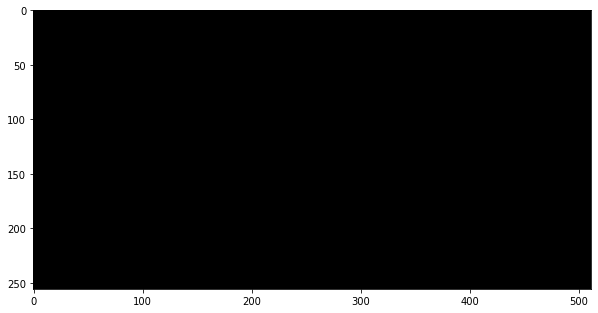

noisy


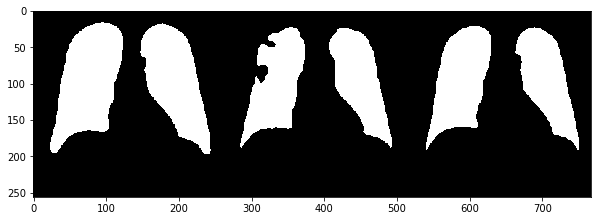

CONVERT_JPCNN055.png


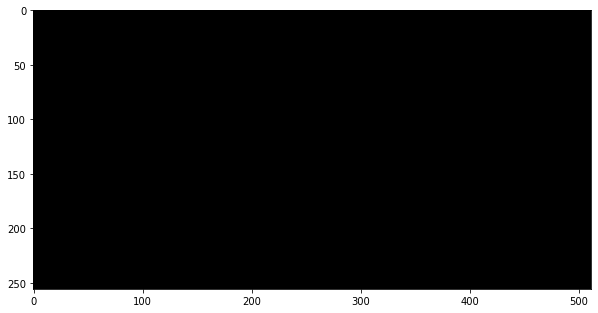

noisy


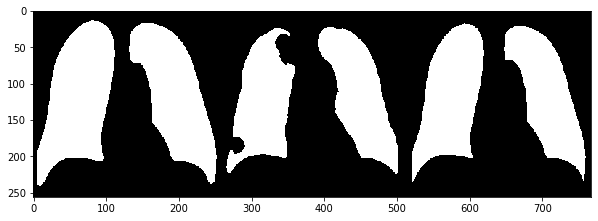

CONVERT_JPCNN057.png


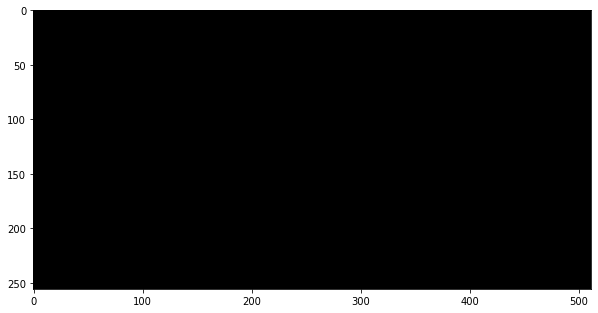

noisy


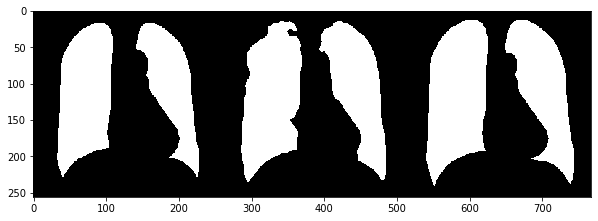

CONVERT_JPCNN059.png


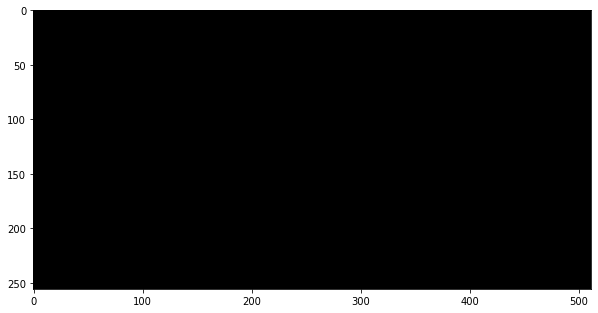

noisy


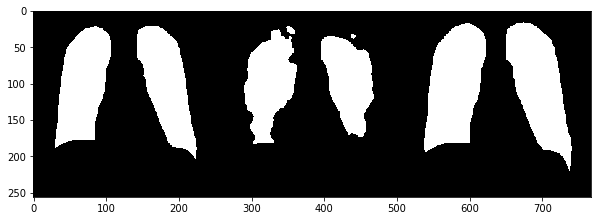

CONVERT_JPCNN061.png


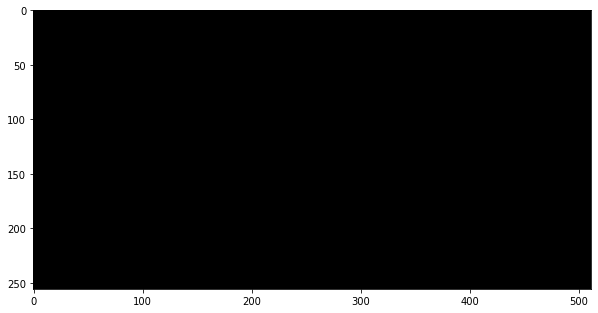

noisy


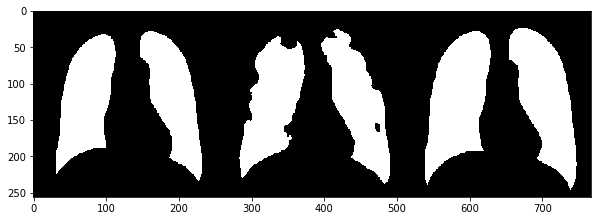

CONVERT_JPCNN063.png


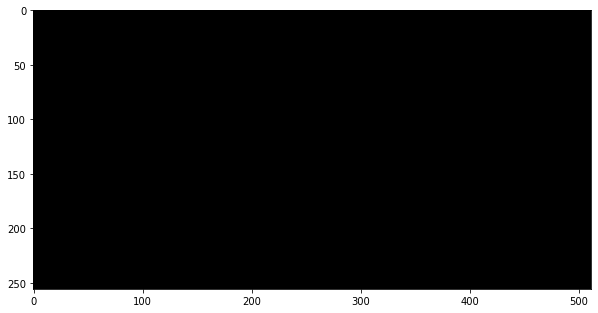

noisy


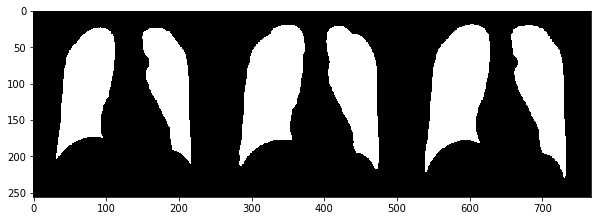

CONVERT_JPCNN065.png


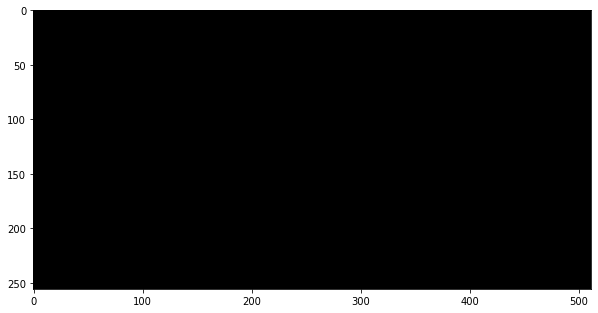

noisy


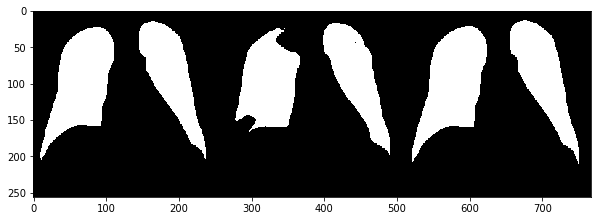

CONVERT_JPCNN067.png


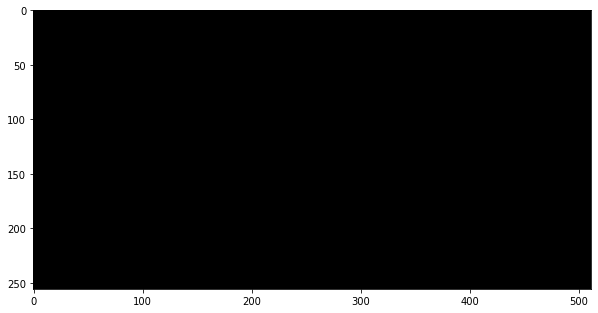

noisy


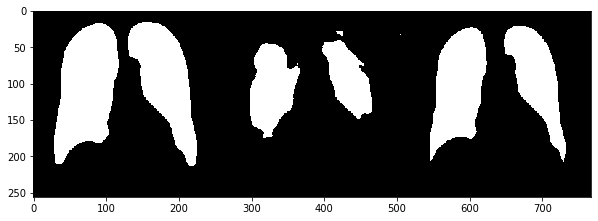

CONVERT_JPCNN069.png


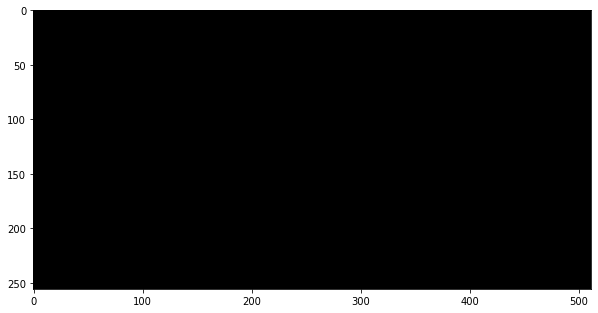

noisy


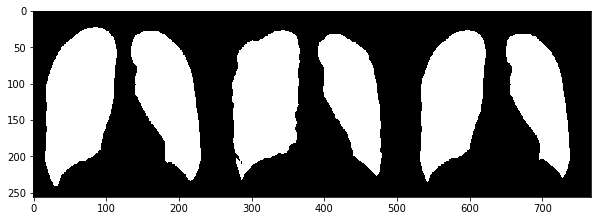

CONVERT_JPCNN071.png
CONVERT_JPCNN073.png
CONVERT_JPCNN075.png


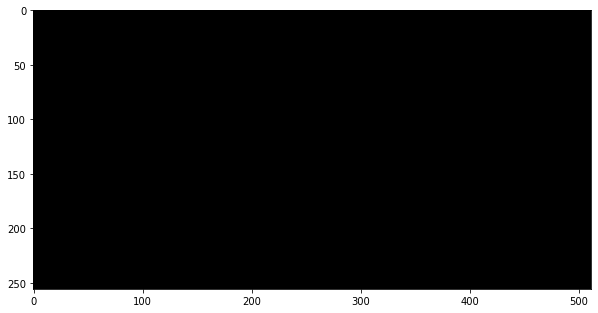

noisy


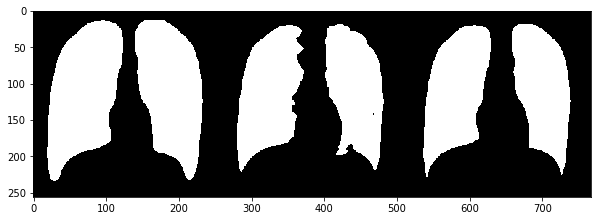

CONVERT_JPCNN077.png
CONVERT_JPCNN079.png


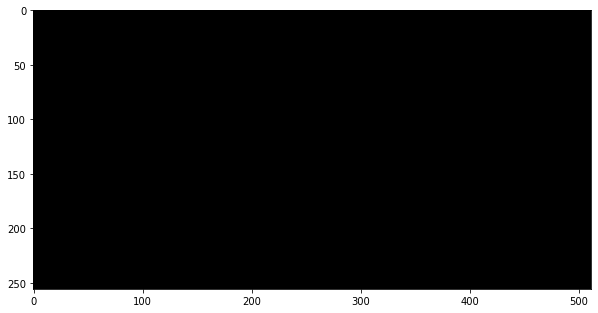

noisy


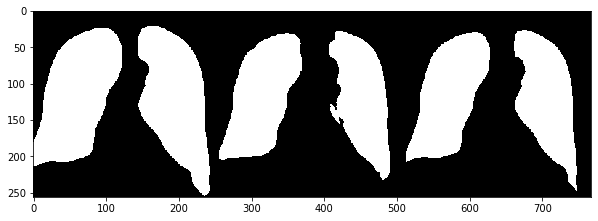

CONVERT_JPCNN081.png


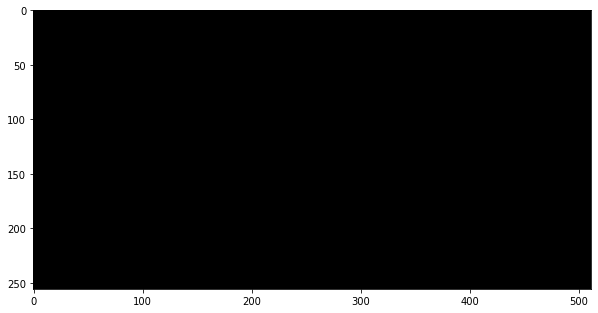

noisy


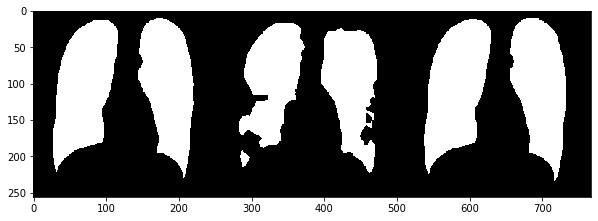

CONVERT_JPCNN083.png
CONVERT_JPCNN085.png


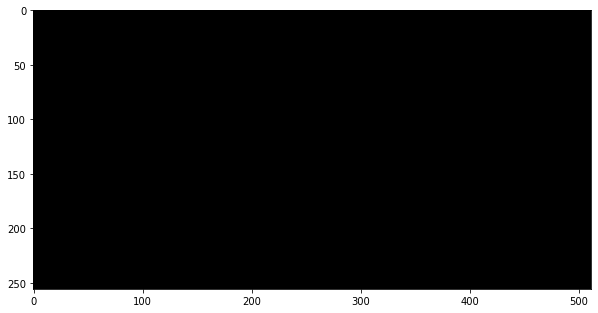

noisy


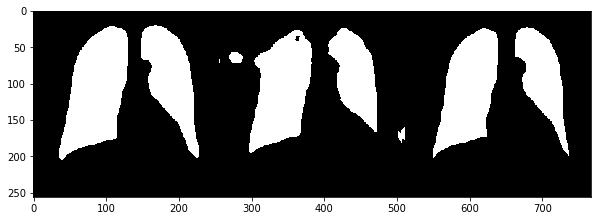

CONVERT_JPCNN087.png
CONVERT_JPCNN089.png


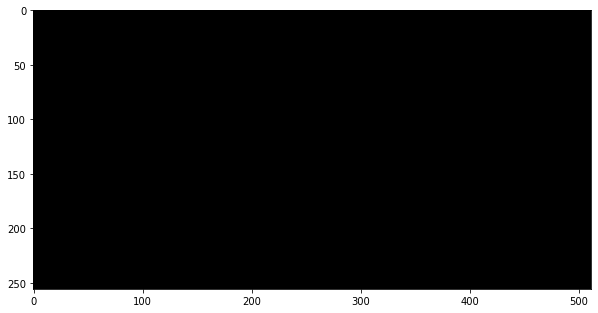

noisy


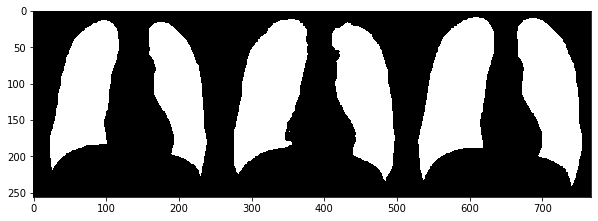

CONVERT_JPCNN091.png


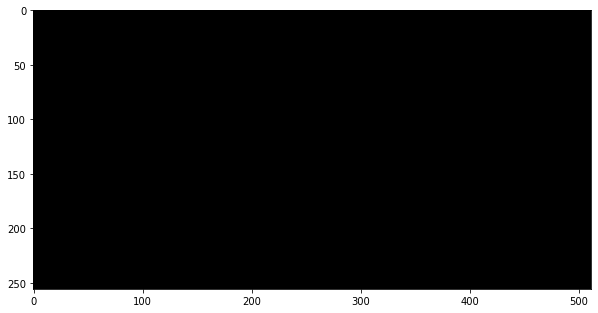

noisy


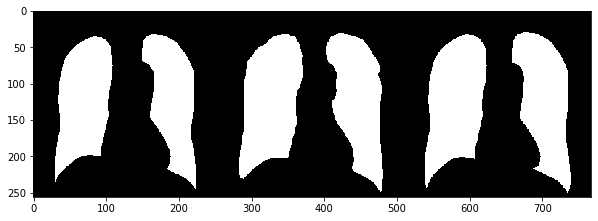

CONVERT_JPCNN093.png


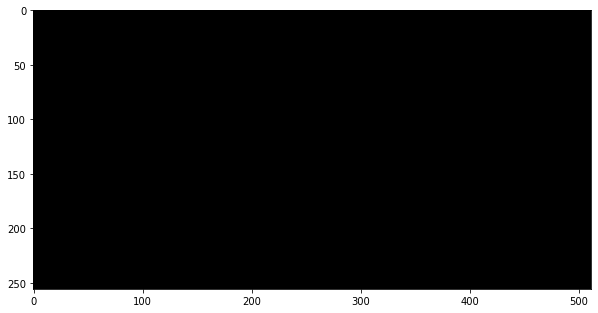

clean


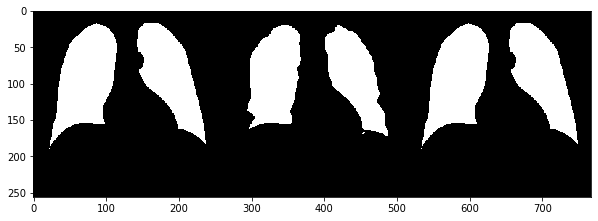

In [24]:
for j in range(len(filenames_im)):
    print(filenames_im[j])
    if j in max_index_k:
        im = images[j].copy()
        im = im*1.0/np.max(im)
        im = im.reshape((1,1,im.shape[0], -1))
        im = torch.from_numpy(im)
        X = Variable(im).cuda().float()
        out_map = []
        number_dropout = 5
        for k in range(number_dropout):
            output = model(X)
            output2 = output.data.cpu().numpy()
            output2 = np.squeeze(output2[0])

            output2 = np.argmax(output2,0)
            output2 = np.squeeze(output2)
            pred = cv2.imread(cwd + '\\medical_images\\prediction\\' + filenames_im[j], 0)
            out_result = np.zeros(pred.shape)
            out_result[pred != output2] = 1.0
            out_map.append(out_result)

        out_map = np.array(out_map)
        out_map = np.sum(out_map, 0)/number_dropout
        uncertainty_map = np.zeros(out_map.shape)
        uncertainty_map[out_map > 0.2] = 1

        noisy_lb = lbs[j].copy()
        noisy_lb[noisy_lb > 1] = 1
        gt = gts[j].copy()
        gt[gt > 1] =1
        re = np.concatenate((uncertainty_map, out_map), 1) 
        plt.imshow(re)
        plt.show()
        
        if len(np.unique(gt-noisy_lb)) == 1:
            print('clean')
        else:
            print('noisy')
        pred[uncertainty_map == 1] = noisy_lb[uncertainty_map == 1] 
        re = np.concatenate((noisy_lb, pred, gt), 1)
        plt.imshow(re)
        plt.show()
    else:
        pred = lbs[j].copy()
    save_path = cwd + '\\medical_images\\updated_label\\' + filenames_im[j]
    cv2.imwrite(save_path, pred*200)